# Problem Statement:
### Given pickup and dropoff locations, the pickup timestamp, and the passenger count, the objective is to predict the fare of the taxi ride using Random Forest

In [1]:
import pandas as pd
import seaborn as  sns
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('TaxiFare.csv')
data.head()

,unique_id,amount,date_time_of_pickup,longitude_of_pickup,latitude_of_pickup,longitude_of_dropoff,latitude_of_dropoff,no_of_passenger
0,26:21.0,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,52:16.0,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,35:00.0,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,30:42.0,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,51:00.0,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# Eda

In [3]:
data_new = data.copy()

In [4]:
data_new.shape

(50000, 8)

In [5]:
data_new.isna().sum()

unique_id               0
amount                  0
date_time_of_pickup     0
longitude_of_pickup     0
latitude_of_pickup      0
longitude_of_dropoff    0
latitude_of_dropoff     0
no_of_passenger         0
dtype: int64

In [6]:
data_new.duplicated().sum()

0

In [7]:
data['no_of_passenger'].value_counts()

no_of_passenger
1    34808
2     7386
5     3453
3     2183
4     1016
6      989
0      165
Name: count, dtype: int64

- in passengers columns 0 should not be there bcoz passengers cant be zero

<Axes: xlabel='no_of_passenger', ylabel='count'>

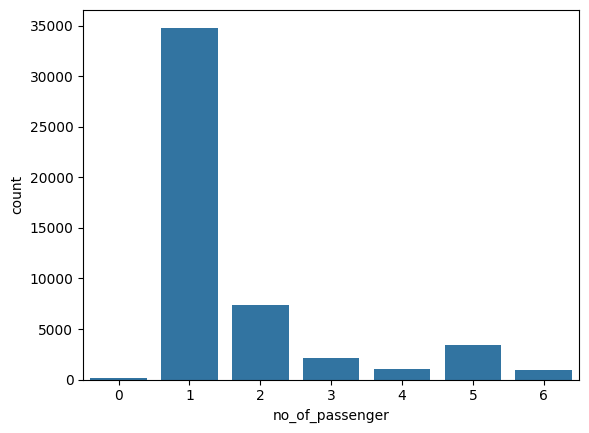

In [8]:
sns.barplot(data_new['no_of_passenger'].value_counts())

<Axes: ylabel='amount'>

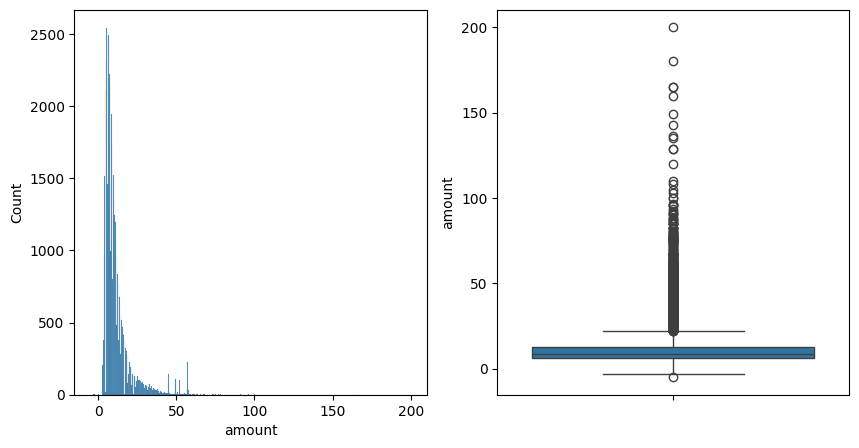

In [9]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.histplot(data['amount'])

plt.subplot(1,2,2)
sns.boxplot(data['amount'])

# creating new Features 

In [10]:
data_new['pick_datetime'] = pd.to_datetime(data_new['date_time_of_pickup'])
data_new['hour'] = data_new['pick_datetime'].dt.hour
data_new['week'] = data_new['pick_datetime'].dt.dayofweek
data_new['month'] = data_new['pick_datetime'].dt.month

In [11]:
data_new.drop(index=5686,inplace=True)

In [12]:
from geopy.distance import geodesic

def calculate_distance(row):
    start = (row['latitude_of_pickup'],row['longitude_of_pickup'])
    end = (row['latitude_of_dropoff'],row['longitude_of_dropoff'])
    return geodesic(start,end).kilometers

data_new['distance_km'] = data_new.apply(calculate_distance,axis=1)

# data cleaning

In [13]:
data_new.drop(index = data_new[data_new['no_of_passenger'] == 0].index,inplace=True)

In [14]:
data_new.drop(index=data_new[data_new['distance_km'] == 0].index,inplace=True)

# Feature importance

In [15]:
X = data_new[['no_of_passenger','hour','week','month','distance_km']]
y = data_new['amount']

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100,random_state=42)
model.fit(X,y)

RandomForestRegressor(random_state=42)

In [18]:
df = pd.DataFrame({'feature':X.columns,'importance': model.feature_importances_})
df.sort_values(by='importance',ascending=False)

,feature,importance
4,distance_km,0.883328
1,hour,0.043344
3,month,0.032775
2,week,0.026235
0,no_of_passenger,0.014318


- we can leave out last two features

# base model building

In [43]:
X_selected = X[['distance_km', 'hour', 'month','week']]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
rf_base_model = RandomForestRegressor(n_estimators=100,max_depth=9,min_samples_split=5,min_samples_leaf=6 , random_state=42)

In [44]:
rf_base_model.fit(X_train, y_train)
y_pred = rf_base_model.predict(X_test)

In [45]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, y_pred)
print("R-Squared (R²):", r2)

R-Squared (R²): 0.802578203089897


# Tunning

In [ ]:
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestRegressor
# import numpy as np

# # Define the hyperparameter distribution
# param_dist = {
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [None, 10, 20, 30, 50],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt', 'log2']
# }

# # Initialize the Random Forest Regressor
# rf = RandomForestRegressor(random_state=42)

# # Initialize RandomizedSearchCV with scoring='r2'
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_dist,
#                                    n_iter=100, cv=5, verbose=2, random_state=42,
#                                    n_jobs=-1, scoring='r2')

# # Fit the model (this step is critical)
# random_search.fit(X_train, y_train)

# # After fitting, access the best parameters
# if hasattr(random_search, 'best_params_'):
#     print("Best Parameters:", random_search.best_params_)
# else:
#     print("RandomizedSearchCV has not been fitted properly.")


# boosting algo

In [42]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

# Evaluate the model using R² score
r2_gbr = r2_score(y_test, y_pred)
print("R² Score for Gradient Boosting Regressor:", r2_gbr)


R² Score for Gradient Boosting Regressor: 0.8050317481425572
